# Data Preprocessing

In [7]:
lang_t = 'en'
lang_s = 'fr'
prep_path = "/DATA/preprocess"

In [38]:
import codecs
import numpy as np
from utils import *
import nltk.data
import random
import nltk
from multiprocessing import Pool
import multiprocessing as mp
import string

def remove_punc(text):
    # Needs to keep stops like L.A.P.D.
    # almost all other punctuation needs to be carefully removed
    text = unicode.strip(text)
    text = unicode.replace(text, " .", u"")
    text = unicode.replace(text,",", u"")
    text = unicode.replace(text,u" .", u"")
    text = unicode.replace(text,u" ,", u"")
    text = unicode.strip(text,",:)(][}{!")
    text = unicode.strip(text,u",:)(][}{;!")
    text = unicode.replace(text,u':', u'')
    text = text.replace(u';', u'')
    text = text.replace(')', u'')
    text = text.replace("(", u'')
    #text = text.replace(u"     ", " ")
    text = text.replace(u"    ", " ")
    text = text.replace(u"   ", " ")
    text = text.replace(u"  ", " ")
    '''text = text.replace(u"9", "9 ")
    text = text.replace(u"8", "8 ")
    text = text.replace(u"7", "7 ")
    text = text.replace(u"6", "6 ")
    text = text.replace(u"5", "5 ")
    text = text.replace(u"4", "4 ")
    text = text.replace(u"3", "3 ")
    text = text.replace(u"2", "2 ")
    text = text.replace(u"1", "1 ")
    text = text.replace(u"0", "0 ")'''
    return text



f1_fr = codecs.open("DATA/en-fr_paropt/dev.tok.fr", encoding='utf-8')
f2_fr = codecs.open("DATA/en-fr_paropt/train.fr", encoding='utf-8')
#test_fr = codecs.open("DATA/en-fr_paropt/test.fr", encoding='utf-8')
raw_source = remove_punc(eval("f1_"+lang_s).read()+"\n"+eval("f2_"+lang_s).read())


f1_en = codecs.open("DATA/en-fr_paropt/dev.tok.en", encoding='utf-8')
f2_en = codecs.open("DATA/en-fr_paropt/train.en", encoding='utf-8')
#test_en = codecs.open("DATA/en-fr_paropt/test.en", encoding='utf-8')
raw_target = remove_punc(eval("f1_"+lang_t).read()+"\n"+eval("f2_"+lang_t).read())


#i = raw_source.index(u'pr\xe9sident m. rohan')
#print i, raw_source[i:i+60]


print "Corpora aligned: {}".format(len(raw_source.split('\n')) == len(raw_target.split('\n')))

# Split the text up into lines
# Randomise the lists but maintain parallel ordering

s = zip(raw_source.split('\n'), raw_target.split('\n'))

np.random.shuffle(s)
raw_source, raw_target = zip(*s)
del f1_fr, f2_fr, f1_en, f2_en, s
training_fraction = 0.05
tl = int(len(raw_source)*training_fraction)
raw_source_train, raw_target_train = raw_source[tl::], raw_target[tl::]
raw_source_test, raw_target_test = raw_source[0:tl], raw_target[0:tl]
# We need to save the raw test data to file to use for the benchmark model
#save_obj(raw_source_test, "DATA/preprocess_d/raw_source_test")
#save_obj(raw_target_test, "DATA/preprocess_d/raw_target_test")

del raw_target, raw_source
print "\n".join([raw_source_train[1],raw_target_train[1]])
print "------------"
print "\n".join([raw_source_train[303],raw_target_train[303]])
print "------------\n Judging by keywords and rudimentary knowledge of French, are the corpora are still aligned?"
print "corpora still same length with training length: {} and testing: {}:".format(len(raw_source_train), len(raw_source_test)), len(raw_source_train)== len(raw_target_train), '\n'


Corpora aligned: True
Pourtant malgré ses conceptions politiques anachroniques Ortega a de bonnes chances de remporter les élections de novembre 2006
But despite Ortega &aposs anachronistic politics he has a good chance of winning the election in November 2006
------------
Un plan qui montre le deuxième niveau du Musée - les pavillons publics et administratifs
A plan showing the second level of the museum - both the public and the curatorial wings
------------
 Judging by keywords and rudimentary knowledge of French, are the corpora are still aligned?
corpora still same length with training length: 962943 and testing: 50681: True 



In [42]:
import nltk
def tokenize_sentences(text_source, text_target, max_target_length=17):
    new_text_s = []
    new_text_t = []
    flat_s = []
    flat_t = []
    for sent_s, sent_t in zip(text_source, text_target):
        # This splits up tokens within a sentence and removes whitespace from the ends
        tok_s = unicode.strip(sent_s.lower()).split(' ')
        tok_t = unicode.strip(sent_t.lower()).split(' ')
        if len(tok_t)<=max_target_length:
            flat_s += tok_s
            flat_t += tok_t
            # I'm keeping the final punctuation and appending the
            # <EOS> tag after it
            new_text_s.append(tok_s+[u'<EOS>'])
            new_text_t.append(tok_t+[u'<EOS>'])
    print "There are now {} sequence pairs remaining.".format(len(new_text_t))
    print "Corpora still same length: {}".format(len(new_text_t)==len(new_text_s))
    return new_text_s, nltk.FreqDist(flat_s), new_text_t, nltk.FreqDist(flat_t)
print "TRAINING DATA"
source_train_, freq_s, target_train_, freq_t = tokenize_sentences(raw_source_train, raw_target_train)
print "TESTING DATA"
source_test_, _, target_test_, _ = tokenize_sentences(raw_source_test, raw_target_test)

TRAINING DATA
There are now 471148 sequence pairs remaining.
Corpora still same length: True
TESTING DATA
There are now 24959 sequence pairs remaining.
Corpora still same length: True


In [43]:

def word_to_ids(freq_dist, vocab_size, lang):
    total_words = len(freq_dist.keys())
    total_length = sum(freq_dist.values())
    print "{} vocab size restricts to {} percent of total vocab.".format(lang, 100*(float(vocab_size)/total_words))
    vocab = dict(freq_dist.most_common(vocab_size))
    print "vocab size= ",len(vocab.keys())
    covered_with_vocab = sum(vocab.values()) # Total of frequencies
    print "Percentage of whole {} corpus covered by vocab: {}".format(lang,
                                            100*(covered_with_vocab/float(total_length)))
    # IDs begin at 3 because <EOS>=1 and <UNK>=2
    word_to_ids = dict([(word, i+3) for i, word in enumerate(vocab.keys())])
    word_to_ids[u'<UNK>'] = 2
    word_to_ids[u'<EOS>'] = 1
    word_to_ids[u'<PAD>'] = 0
    id_to_words = dict((idx, word) for word, idx in word_to_ids.items())
    return word_to_ids, id_to_words

vocab_size_s = 25000
vocab_size_t = 20000

#word_to_ids(freq_s_d, vocab_size_s_d, lang_s)
print "Source dataset"
word2id_s, id2word_s =  word_to_ids(freq_s, vocab_size_s, lang_s)
n = 60
print "{} most common source words: {}".format(n, freq_s.most_common(n))
print "Full dataset"
word2id_t, id2word_t = word_to_ids(freq_t, vocab_size_t, lang_t)
print "{} most common source words: {}".format(n, freq_t.most_common(n))
print word2id_t['hello'], id2word_t[word2id_t['hello']]


Source dataset
fr vocab size restricts to 13.0261251967 percent of total vocab.
vocab size=  25000
Percentage of whole fr corpus covered by vocab: 94.1882245629
60 most common source words: [(u'de', 337381), (u'la', 176064), (u'les', 152655), (u'et', 142256), (u'le', 130548), (u'des', 128106), (u'\xe0', 123465), (u'l&apos', 121715), (u'd&apos', 98554), (u'en', 84001), (u'un', 69285), (u'est', 64675), (u'du', 64460), (u'une', 60748), (u'a', 56335), (u'pour', 53640), (u'&quot', 48120), (u'dans', 45677), (u'que', 43664), (u'il', 39751), (u'au', 37768), (u'sur', 34661), (u'par', 33381), (u'qui', 30559), (u'pas', 28936), (u'sont', 28784), (u'plus', 28512), (u'ce', 25307), (u'ont', 25132), (u'ne', 22885), (u'\u2022', 22807), (u'nous', 22500), (u'\xe9t\xe9', 21253), (u'se', 21147), (u'ou', 20125), (u'vous', 19621), (u'aux', 19558), (u'avec', 19187), (u's&apos', 19047), (u'n&apos', 18962), (u'qu&apos', 18253), (u'?', 16801), (u'cette', 16558), (u'-', 14318), (u'on', 13827), (u'ces', 13708), (u

In [44]:
import time
from functools import partial

def replace_id_func(sequence, **kwargs):
    word2id=kwargs['wtid']
    ids_sent = [] # sentence with words replaced by ids
    for token in sequence:
        if token not in word2id.keys():
            if token == '<EOS>':
                ids_sent.append(1)
            else:
                ids_sent.append(2)
        else:
            ids_sent.append(word2id[token])
    return ids_sent

def replace_with_word_id(text, wtid, lang):
    '''
    take the list of lists, find FreqDist, replace any
    out of vocabulary words with <UNK> whilst giving each
    token a numerical ID, return new list of lists'''
    ti = time.time()
    prep_text = []
    pool = Pool(processes = 3)
    kwargs = {'wtid': wtid}
    id_text = [i for i in pool.imap(partial(replace_id_func, **kwargs), text, chunksize=10000)]
    print "Replacing words with IDs took {} seconds.".format(time.time()-ti)
    return id_text

s_train = replace_with_word_id(source_train_[0:2000], word2id_s, lang_s)
t_train = replace_with_word_id(target_train_[0:2000], word2id_t, lang_t)
s_test = replace_with_word_id(source_test_[0:200], word2id_s, lang_s)
t_test = replace_with_word_id(target_test_[0:200], word2id_t, lang_t)

Replacing words with IDs took 86.553208828 seconds.
Replacing words with IDs took 42.7258429527 seconds.
Replacing words with IDs took 7.30567884445 seconds.
Replacing words with IDs took 4.9802031517 seconds.


In [45]:
data_dic = {"s_train": source_train, "t_train": target_train, 
                "s_test": source_test, "t_test": target_test,
                "word2id_s": word2id_s, "word2id_t": word2id_t,
                "id2word_s": id2word_s, "id2word_t": id2word_t}

In [46]:
save_obj(data_dic, "data_dic")
print id2word_t
! ls

{0: u'<PAD>', 1: u'<EOS>', 2: u'<UNK>', 3: u'writings', 4: u'institutionalised', 5: u'yellow', 6: u'pony', 7: u'four', 8: u'woods', 9: u'titans', 10: u'hanging', 11: u'woody', 12: u'genre', 13: u'cyprus', 14: u'aggression', 15: u'marching', 16: u'looking', 17: u'canes', 18: u'humming', 19: u'analytic', 20: u'granting', 21: u'eligible', 22: u'electricity', 23: u'&#93', 24: u'&#91', 25: u'unanswered', 26: u'wheeled', 27: u'originality', 28: u'fingernails', 29: u'stain', 30: u'lori', 31: u'impoverishment', 32: u'ebrd', 33: u'lord', 34: u'meadows', 35: u'consumed', 36: u'protestants', 37: u'digit', 38: u'hormone', 39: u'hacked', 40: u'co-operation', 41: u'saskatchewan', 42: u'regional', 43: u'dell', 44: u'appropriation', 45: u'foul', 46: u'politician', 47: u'stabbed', 48: u'bringing', 49: u'markers', 50: u'sichuan', 51: u'disturb', 52: u'basics', 53: u'internally', 54: u'prize', 55: u'wooden', 56: u'clientele', 57: u'at-sea', 58: u'wednesday', 59: u'selections', 60: u'spurred', 61: u'hague

[(u'.', 445641), (u'the', 371589), (u',', 265627), (u'and', 192371)]
[(u'de', 458085), (u'.', 448843), (u',', 331419), (u'la', 238506)]
Full Vocabulary size: 156768
Total proportion are hapaxes: 53.5466421719
Full Vocabulary size: 212038
Total proportion are hapaxes: 52.2877974703


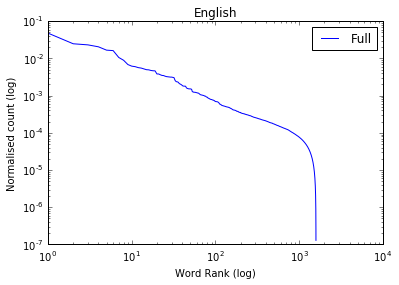

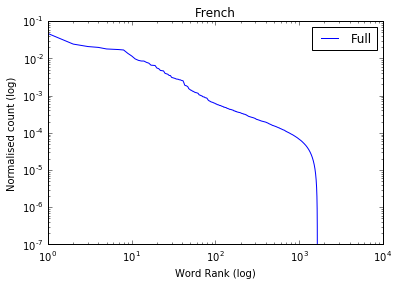

In [23]:
print freq_t.most_common(4)
print freq_s.most_common(4)
import matplotlib.pyplot as plt
import string

def plot_pareto(freq, ax, l):
    counts_list = sorted(set(freq.values()))
    total_counts = float(sum(freq.values()))
    vocab_total= len(freq.keys())
    print "{} Vocabulary size: {}".format(l, vocab_total)
    print "Total proportion are hapaxes: {}".format((len(freq.hapaxes())/float(vocab_total))*100)
    d = dict()
    for word, count in freq.items():
        if word not in string.punctuation.encode('utf-8'):
            if count in d.keys():
                pass
            else:
                d[count] = word
    y, words = tuple(zip(*d.items()))
    x, y = zip(*[(n, count/total_counts) for n,count in enumerate(sorted(y,reverse=True),1)])
    ax.loglog(x,y,label=l)
    ax.set_ylabel("Normalised count (log)")
    ax.set_xlabel("Word Rank (log)")
fig = plt.figure()
ax1 = fig.add_subplot(111)
#plot_pareto(freq_t, ax1, 'Dev.')
plot_pareto(freq_t, ax1, 'Full')
ax1.set_title("English")
plt.legend()
#plt.savefig("English-pareto.pdf")
fig = plt.figure()

ax2 = fig.add_subplot(111)
#plot_pareto(freq_s_d, ax2, 'Dev.')
plot_pareto(freq_s, ax2, 'Full')
ax2.set_title("French")
plt.legend()
#plt.savefig("French-pareto.pdf")
plt.show()
#freqs = freq_t_d.values()
#h, bins_edges = np.histogram(freqs, bins=vocab_size)
#plt.hist(h, bins=bins_edges)



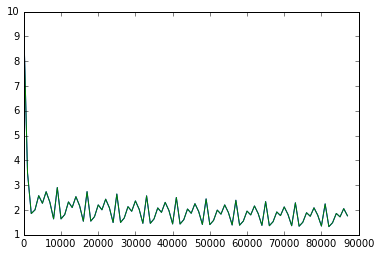

In [147]:
l_128= load_obj("DATA/dev_training/loss_track")
l_128
plt.plot(range(0,88000,1000),l_128)
plt.show()


In [5]:
import logging
import os
import numpy as np
from utils import *
logging.getLogger("tensorflow").setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
logging.basicConfig(level=logging.DEBUG, filename="logfile", filemode="a+",
                        format="%(asctime)-15s %(levelname)-8s %(message)s")

data_path = ""
data_dict = load_obj(data_path+'data_dic')
s_train = data_dict["s_train"]
t_train = data_dict["t_train"]
s_test = data_dict["s_test"]
t_test = data_dict["t_test"]
word2id_s = data_dict["word2id_s"]
word2id_t = data_dict["word2id_t"]
id2word_s = data_dict["id2word_s"]
id2word_t = data_dict["id2word_t"]

vocab_size_t = len(word2id_t.keys())
vocab_size_s = len(word2id_s.keys())

## Load the preprocessed datasets
Need the preprocessed data, the id_to_word dictionaries and word_to_id dictionaries for both source and target languages.

## Evaluation metric:     BLEU Score

Here I use the NLTK implementation of BLEU score to measure how successful the machine translation was.

In [ ]:
from nltk.translate import bleu_score
from utils import remove_EOS_PAD

p_phrase1 = [4,5,4,5,4,5, 1, 0]
t_phrase = [4,5,6,34,8,76, 87, 1]
# Truncate sequences at [1]
t_phrase = remove_EOS_PAD(t_phrase)
p_phrase1 = remove_EOS_PAD(p_phrase1)

print "BLEU1 score test is {}.".format(
    bleu_score.corpus_bleu([[t_phrase]], [p_phrase1], weights=([1])))
print "BLEU2 score test is {}.".format(
    bleu_score.corpus_bleu([[t_phrase]], [p_phrase1], weights=([0.5,0.5])))

## Benchmark model

Here I use the [GoogleTrans]() python package to translate the corpus by translating each individual word in the text. There seems to be an issue with the number of JSON requests the model makes to the Google Translate service, so it needs to work in passes. If a phrase is skipped due to a JSON error, keep it stored and try again later (with a new Translator instance).

In [75]:
from googletrans import Translator


def googletrans_pass(s_text, target_lang='fr'):
    translator = Translator()
    trans_corpus = []
    skipped_phrases = []
    for i, phrase in s_text:
        try:
            trans_corpus.append((i, [trans.text for 
                            trans in translator.translate(phrase, dest=target_lang)]))
        except ValueError as err:
            # Making a new Translator instance seems to help JSON errors
            translator = Translator()
            skipped_phrases.append((i, phrase))
            print "{} for phrase {}".format(err, i)
    return trans_corpus, skipped_phrases

def translate_word_by_word(source_text):
    # Need to keep track of phrase ordering by labelling
    source_text = [(i, phr) for i, phr in enumerate(source_text)]
    trans_text, skipped_phrases = googletrans_pass(source_text, target_lang=lang_t)
    print "There are {} phrases which could not be translated first time around.".format(
                                                                    len(skipped_phrases))
    # Keep making passes until there are no more untranslated phrases left
    j = 2
    while len(skipped_phrases)>0:
        translated_corpus = []
        tc_s, skipped_phrases = googletrans_pass(skipped_phrases, target_lang=lang_t)
        trans_text += tc_s
        print "There are {} phrases which could not be translated in pass {}.".format(
                                                            len(skipped_phrases), j)
        j+=1
    # Sort the phrases via their labels.
    # Sorted function gives ([indices], [phrases]) so just need 2nd element
    trans_text = zip(*sorted(zip(*BM_translated)))[1]
    return trans_text

BM_translated = translate_word_by_word(raw_source_test)
print "Corpus translated from {} to {}".format(lang_s, lang_t)


No JSON object could be decoded for phrase 46
No JSON object could be decoded for phrase 87
No JSON object could be decoded for phrase 132
No JSON object could be decoded for phrase 166
No JSON object could be decoded for phrase 217
No JSON object could be decoded for phrase 263
No JSON object could be decoded for phrase 316
No JSON object could be decoded for phrase 373
No JSON object could be decoded for phrase 430
No JSON object could be decoded for phrase 479
No JSON object could be decoded for phrase 526
No JSON object could be decoded for phrase 581
No JSON object could be decoded for phrase 630
No JSON object could be decoded for phrase 683
No JSON object could be decoded for phrase 742
No JSON object could be decoded for phrase 798
No JSON object could be decoded for phrase 1025
No JSON object could be decoded for phrase 1074
No JSON object could be decoded for phrase 1117
No JSON object could be decoded for phrase 1329
No JSON object could be decoded for phrase 1519
No JSON ob

KeyboardInterrupt: 

In [74]:
print " ".join(raw_source_test[60])
print " ".join(BM_translated[60])
print " ".join(raw_target_test[60])

Une des raisons de l&apos; échec de &quot; The Hunting Party &quot; est que l&apos; on ne laisse simplement pas Simon Hunt être le cynique déserté doté d&apos; un cœur , comme il nous est présenté au début .
A of the reasons from l&apos; failure from &quot; The Hunting Party &quot; East what l&apos; on born leash simply not Simon Hunt be the cynical deserted with d&apos; a heart , as the we East present the beginning .
One of the reasons why &quot; The Hunting Party &quot; fails is that Simon Hunt isn &apos;t allowed to simply be the run-down cynic with a heart of gold we &apos;re introduced to at the beginning .


In [ ]:
test_targets = [[ids_to_phrases(phrase,id_to_word_t)]for phrase in test_t]

BM_BLEU4 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=(0.25,0.25, 0.25,0.25))
BM_BLEU2 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=(0.5,0.5))
BM_BLEU1 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=([1]))

print "Actual: \n", (" ".join(test_targets[10])).encode('utf-8')
print "Prediction: \n", (" ".join(BM_translated_corp[10])).encode('utf-8')
print "Unigram BLEU score is {}.".format(BM_BLEU1)
print "Bigram BLEU score is {}.".format(BM_BLEU2)
print "4-Gram BLEU: {}".format(BM_BLEU4)

# Word IDs and word-to-vec vectors

Since we are interested in the process of learning weights within the RNNs to predict seq2seq mappings rather than embeddings I have chosen to use pretrained word embeddings ino order to cut down training time. [THis is](https://sites.google.com/site/rmyeid/projects/polyglot#TOC-Download-the-Embeddings) where the embeddings are from.

In [8]:
import pickle
import numpy as np
def get_embeddings(id_to_word, lang):
    # We load pretrained word2vec embeddings from polyglot to save on training time
    filename ='DATA/polyglot-'+lang+'.pkl'
    pretrain_vocab, pretrain_embed = pickle.load(open(filename, 'rb'))
    embed_vocab = [pretrain_embed[pretrain_vocab.index('<PAD>')], pretrain_embed[pretrain_vocab.index('</S>')]]
    skip_count = 0
    skipped_words = []
    for idx, word in sorted(id_to_word.items()[2::]):
        try:
            pretrain_idx = pretrain_vocab.index(word)
            embed_vocab.append(pretrain_embed[pretrain_idx])
        except ValueError:
            try:
                # it could be that the word is a name which needs to 
                # be capitalized. Try this...
                pretrain_idx = pretrain_vocab.index(str(word.title()))
                embed_vocab.append(pretrain_embed[pretrain_idx])
            except ValueError:
                try:
                    # it could be that the word is an achronym which needs to 
                    # be upper case. Try this...
                    pretrain_idx = pretrain_vocab.index(word.upper())
                    embed_vocab.append(pretrain_embed[pretrain_idx])
                except ValueError:
                    # Give up trying to find an embedding.
                    # How many words are skipped? Which ones?
                    skip_count +=1
                    skipped_words.append(word)
                    # Let's just initialise the embedding to a random normal distribution
                    embed_vocab.append(np.random.normal(loc=0.0, scale=np.sqrt(2)/4, size=64))
    embed_vocab = np.array(embed_vocab, dtype=np.float32)
    print "The embedding matrix for {} has {} columns and {} rows.".format(lang, 
                                                embed_vocab.shape[0], embed_vocab.shape[1])
    print "{} vocab words were not in the {} embeddings file.".format(skip_count, lang)
    return embed_vocab, skipped_words
# the ith word in words corresponds to the ith embedding 

embed_vocab_s, skipped_s = get_embeddings(id2word_s, lang=lang_s)
embed_vocab_t, skipped_t = get_embeddings(id2word_t, lang=lang_t)
print skipped_t

The embedding matrix for fr has 25003 columns and 64 rows.
3093 vocab words were not in the fr embeddings file.
The embedding matrix for en has 20003 columns and 64 rows.
2001 vocab words were not in the en embeddings file.
[u'&#93', u'&#91', u'impoverishment', u'ebrd', u'co-operation', u'at-sea', u'south-west', u'17000', u'high-performing', u'275', u'receivables', u'counter-terrorism', u'three-', u'2008-2009', u'&aposll', u'99', u'tangles', u'91', u'90', u'95', u'94', u'97', u'genevi\xe8ve', u'f\xe9in', u'double-edged', u'that..', u'peacebuilding', u'pyjamas', u'18th', u'1-15', u'lower-cost', u'amnesty..', u'eighty-six', u'accrual', u'hizbollah', u'coronavirus', u'shutdowns', u'no.5', u'underfoot', u'shipper', u'1970s', u'no.8', u'loss-making', u'wasn', u'172', u'170', u'202', u'mckinsey', u'205', u'cross-reference', u'&aposconnor', u'megadroid', u'2012-2013', u'khrushcheva', u'cross-examination', u'rou\u010dek', u'reschedule', u'five-week', u'hi-tech', u'year-on-year', u'pre-empt', u

** We can see above ** that the English words which were not in the embedding files are fairly specialist words or numerical values (which are the same in French) so hopefully they won't be too much of a problem.

In [49]:
#from utils import format_batch
test_x = [[5,2,3],[2], [4,2], [1,2]]
# it's going to go from the number of cols being the sequence length/ num of rows being batch size
# to the number of rows being the max sequence length/ num cols being batch size
# Essentially like a padding and then transpose
def format_batch(x):
    seq_lengths = [len(row) for row in x]
    n_batches = len(x)
    max_seq_length = max(seq_lengths)
    outputs = np.zeros(shape=(max_seq_length, n_batches),dtype=np.int32)
    for i in range(len(seq_lengths)):
        for j in range(seq_lengths[i]):
            outputs[j][i] = x[i][j]
    return outputs

print format_batch(test_x)
print np.array(format_batch(source_train[0:7]))

[[5 2 4 1]
 [2 0 2 2]
 [3 0 0 0]]
[[ 7918  9196  7408 10623  6866 14876 10007]
 [15966 17183 14549 23542  8267 18930 13305]
 [20240  3810 16068 10829 11873  9616 10517]
 [ 9137  8267 10538  8267     1 19096 15796]
 [  403 24855 21589  2632     0 10829  7684]
 [ 5294  8279  7408 15796     0 17741 11297]
 [11271 20581 16270  9070     0  3162 12933]
 [ 6054 10619 19982 11271     0 20845  4351]
 [10007  2904  4820     2     0     1 16358]
 [13517     1  7408  8279     0     0 19096]
 [  190     0  4782  7948     0     0 20565]
 [16358     0  4409 14199     0     0     1]
 [19096     0 15966     1     0     0     0]
 [24224     0  8716     0     0     0     0]
 [16392     0   976     0     0     0     0]
 [    1     0 19096     0     0     0     0]
 [    0     0 13537     0     0     0     0]
 [    0     0 19984     0     0     0     0]
 [    0     0 19096     0     0     0     0]
 [    0     0  2712     0     0     0     0]
 [    0     0 12276     0     0     0     0]
 [    0     0     2  

Very pleasing...

# Building the network

In [29]:
import tensorflow as tf

tf.reset_default_graph()
input_embedding_size = 64 # Fixed due to pretrained embedding files
encoder_hidden_units = 128
decoder_hidden_units = encoder_hidden_units # Must be the same at the moment

In [30]:

encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
encoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_s, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_t, decoder_inputs)
with tf.device("/cpu:0"):
    encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs_embedded,
                                                     dtype=tf.float32, time_major=True)
with tf.device("/cpu:1"):
    decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

    decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                    decoder_cell, decoder_inputs_embedded,
                    initial_state=encoder_final_state,
                    dtype=tf.float32, time_major=True,
                    scope="plain_decoder")
    decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size_t)
    """
    #weights
    W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)
    #bias
    b = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)
    decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
    # why do we only flatten the tensor so it's rank 2?
    decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
    #feed flattened tensor through projection
    decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
    # make the logits the shape of the
    decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))
    """
with tf.device("/cpu:2"):
    decoder_prediction = tf.argmax(decoder_logits, axis=2)
    timestep_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.one_hot(decoder_targets, depth=vocab_size_t,
                          dtype=tf.float32),logits=decoder_logits)
    print timestep_cross_entropy
    # loss is the mean of the cross entropy
    loss = tf.reduce_mean(timestep_cross_entropy)
    tf.summary.scalar('loss', loss)
    # We use AdaM which combines AdaGrad (parameters updated less often get updated more 	strongly)
    # and momentum (updates depend on the slope of previous updates - avoiding local minima)
    train_op = tf.train.AdamOptimizer().minimize(loss)

Tensor("Reshape_2:0", shape=(?, ?), dtype=float32, device=/device:CPU:2)


In [31]:
"""#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
# why do we only flatten the tensor so it's rank 2?
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#feed flattened tensor through projection
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
# make the logits the shape of the 
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))

print decoder_logits"""

"#weights\nW = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)\n#bias\nb = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)\ndecoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))\n# why do we only flatten the tensor so it's rank 2?\ndecoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))\n#feed flattened tensor through projection\ndecoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)\n# make the logits the shape of the \ndecoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))\n\nprint decoder_logits"

In [32]:
def batch_source_target(source, target, batch_size):
    assert len(source) == len(target)
    for start in range(0, len(source), batch_size):
        end = min(start + batch_size, len(source))
        #print type(source[start:end])
        #print len(target[start:end])
        yield source[start:end], target[start:end]


def make_feed_dict(fd_keys, s_batch, t_batch, reverse_encoder_inputs= False):
    encoder_inputs_ = format_batch(s_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in s_batch])
    decoder_inputs_ = format_batch([[1]+sequence[0:-1] for sequence in t_batch])
    decoder_targets_ = format_batch([sequence for sequence in t_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }



def make_test_feed_dict(fd_keys,s_batch, t_batch, reverse_encoder_inputs= False):
    # At testing time, we can't supervise the decoder layer with
    # the 'gold truth' example as input, so we instead feed in
    # word generated at  previous timestep. This is (apparently)
    # equivalent to feeding in zeros for the decoder inputs
    encoder_inputs_ = format_batch(s_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in s_batch])
    decoder_targets_ = format_batch([sequence for sequence in t_batch])
    decoder_inputs_ = format_batch([[0]*len(sequence) for sequence in t_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }

# Test everything is working okay

batch_size = 100

for s_sample_batch, t_sample_batch in batch_source_target(s_train[0:2], t_train[0:2], batch_size):
    fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
    fd = make_feed_dict(fd_keys, s_sample_batch, t_sample_batch)
    fd_r = make_feed_dict(fd_keys, s_sample_batch, t_sample_batch, reverse_encoder_inputs= True)
    fd_t = make_test_feed_dict(fd_keys, s_sample_batch, t_sample_batch, reverse_encoder_inputs= False)
    assert len(fd.values()[0].T[0]) == len(fd_r.values()[0]) # reversed list must be the same length as original
    print fd.keys()[0]
    print ids_to_phrases(np.array(fd.values()[0]).T[0], id2word_s)
    print np.array(fd.values()[0]).T[0], "\n"
    #print "Reversed as in Sutskever et al. "
    #print np.array(fd_r.values()[0]).T[0]
    assert len(fd.values()[1].T[0]) == len(fd.values()[1].T[1]) # decoder inputs and targets must be the same
    for i in range(1, len(fd.keys())):
        print fd.keys()[i]
        ph = ids_to_phrases(np.array(fd.values()[i]).T[0], id2word_t)
        print ph
        print np.array(fd.values()[i]).T[0]
    
    print "Decoder inputs at test time"
    print np.array(fd_t.values()[1]).T[0]
    break


Tensor("encoder_inputs:0", shape=(?, ?), dtype=int32)
they qwerty scandinaves transmissibles disposés supprimés surcharge audacieuse chaotique normale eût chris dauphins derrick peints 
[ 7918 15966 20240  9137   403  5294 11271  6054 10007 13517   190 16358
 19096 24224 16392     1] 

Reversed as in Sutskever et al. 
[16392 24224 19096 16358   190 13517 10007  6054 11271  5294   403  9137
 20240 15966  7918     1]
Tensor("decoder_inputs:0", shape=(?, ?), dtype=int32)

[    1  1565  7485  6620 19749  1045   262 11773  9713 12656   974  2425
 12834  2524  3982 16733]
Tensor("decoder_targets:0", shape=(?, ?), dtype=int32)
misplaced ridden drop know attendees hot lap sofia compilation bnp follow-up théâtre midwest bent skillfully 
[ 1565  7485  6620 19749  1045   262 11773  9713 12656   974  2425 12834
  2524  3982 16733     1]
Decoder inputs at test time
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
loss_track = []

[u'<PAD>', u'<EOS>', u'<UNK>', u'accueille', u'woods', u'accueilli', u'yougoslavie', u'&#93', u'&#91', u'lib\xe9r\xe9s', u'embl\xe9matiques', u'lib\xe9r\xe9e', u'd\xe9verser', u'savaient', u'touristes', u'adoptent', u'consid\xe9rable', u'liaisons', u'pr\xe9c\xe9d\xe9', u'controvers\xe9', u'chaussure', u'270', u'miniatures', u'274', u'275', u'276', u'n\u0153ud', u'resserrement', u'originalit\xe9', u'recyclage', u'familles', u'st\xe9r\xe9otypes', u'abr\xe9viations', u'pourparlers', u'chine', u'china', u'kids', u'm\xe9tabolisme', u'naturel', u'a\xe9riens', u'controverse', u'kidd', u'nomades', u'golden', u'projection', u'p\xe9cheur', u'comp\xe9titives', u'modifi\xe9s', u'traiteur', u'2.2.1', u'stern', u'modifi\xe9e', u'sensibilisation', u'dna', u'transport\xe9e', u'1892', u'music', u'holistique', u'voyageur', u'comp\xe9titions', u'populations', u'yahoo', u'kampala', u'commentaire', u'observateurs', u'h\xe9ritier', u'avaient', u'wang', u'merveilleuses', u'th\xe9oriquement', u'rythme', u'bie

In [60]:
import time

def format_idx(idx):
    # Just cuts out the padding of word index lists
    li = []
    for i in idx:
        if i ==0:
            break
        else:
            li.append(i)
    return li

BLEU = []
epochs = 30 # How many times we loop over the whole training data
batch_size = 92 # After how many sequences do we update the weights?
print "there will be {} samples in the final batch".format(len(source_train)%batch_size)
fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
try:
    batch_n = 0
    ti = time.time()
    print "training has begun..."
    for epoch in range(1,epochs+1):    
        for s_batch, t_batch in batch_source_target(source_train, target_train, batch_size):
            feed_dict = make_feed_dict(fd_keys, s_batch, t_batch)
            _, l = sess.run([train_op, loss], feed_dict)
            if (batch_n==0) or (batch_n%100) == 0:
                loss_track.append(l)
                print "epoch {}".format(epoch)
                print 'batch {}'.format(batch_n)
                print 'loss: {}'.format(sess.run(loss, feed_dict))
                predict_ = sess.run(decoder_prediction, feed_dict)
                #predictions = [remove_EOS_PAD(pred) for pred in predict_.T]
                #actuals = [[remove_EOS_PAD(act)] for act in fd[decoder_targets].T]
                #BLEU2 = bleu_score.corpus_bleu(actuals, predictions, weights=(0.5,0.5))
                #BLEU.append(BLEU2)
                i =1
                for (inp, act, pred) in zip(feed_dict[encoder_inputs].T,
                                                         feed_dict[decoder_targets].T,
                                                         predict_.T)[10:12]:
                    print '  sample {}:'.format(i)
                    print '    input     > {} \n {}'.format(
                        format_idx(inp), ids_to_phrases(inp, id2word_s))
                    print '    actual     > {} \n {}'.format(
                        format_idx(act), ids_to_phrases(act, id2word_t))
                    print '    predicted     > {} \n {}'.format(
                        format_idx(pred), ids_to_phrases(pred, id2word_t))
                    i+=1
            batch_n += 1
            
    print 'Training is complete'
except KeyboardInterrupt:
    print 'training interrupted'



there will be 64 samples in the final batch
training has begun...
epoch 1
batch 0
loss: 1.89692986012
  sample 1:
    input     > [1187, 1529, 1703, 4602, 2, 3396, 1078, 1703, 2, 718, 3556, 2644, 2433, 1187, 3503, 1538, 2, 1170, 4970, 226, 1] 
 l&apos; associé de m. <UNK> s&apos; occupe de <UNK> au canada est aussi l&apos; agent qui <UNK> les fournisseurs . 
    actual     > [2077, 2, 286, 2344, 4404, 3255, 3499, 707, 5482, 3443, 2, 1022, 243, 1] 
 mr. <UNK> has a partner in canada as his agent <UNK> suppliers . 
    predicted     > [1784, 2, 2, 2, 2, 5233, 1784, 2, 2, 2, 5233, 2, 243, 1] 
 the <UNK> <UNK> <UNK> <UNK> of the <UNK> <UNK> <UNK> of <UNK> . 
  sample 2:
    input     > [2355, 941, 2118, 3146, 4276, 4902, 1703, 1362, 1098, 2, 1410, 1098, 3108, 2, 226, 1] 
 a première vue , la profondeur de ce &quot; <UNK> politique &quot; semble <UNK> . 
    actual     > [708, 3516, 2, 3089, 1784, 2613, 5233, 1191, 1084, 3483, 4038, 1084, 5198, 3575, 243, 1] 
 at first <UNK> , the depth of 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_track)), loss_track)
#l = [s for i,s in sorted(zip([len(row) for row in l], l))]